#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [2]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, x_train, y_train):
        class_counts = Counter(y_train)
        self.priors = {cls: count / len(y_train) for cls, count in class_counts.items()}
        
        for cls, count in class_counts.items():
            data = x_train[y_train == cls]
            feature_prob = []
            for feature in range(data.shape[1]):
                feature_class_count = Counter(data[:,feature])
                feature_prob.append({value: feature_count / count for value, feature_count in feature_class_count.items()})
            self.likelihoods[cls] = feature_prob

    @staticmethod
    def data_discretization(data, ranges):
        min_val = np.min(data, axis=0)
        max_val = np.max(data, axis=0)
        bins = np.linspace(min_val, max_val, ranges+1)
        bins[ranges] += 0.01
        discretized = np.empty((data.shape[0], 0), dtype=np.int64)
        for i in range(data.shape[1]):
            discretized = np.column_stack((discretized, np.digitize(data[:,i], bins[:,i])))
        return discretized


    def predict(self, sample):
        postori = {}
        
        for cls, prob in self.priors.items():
            for feature in range(len(sample)):
                prob *= self.likelihoods[cls][feature].get(sample[feature], 1e-6)
            postori[cls] = prob
        
        return max(postori, key=postori.get)
            


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, x_train, y_train):
        class_counts = Counter(y_train)
        self.priors = {cls: count / len(y_train) for cls, count in class_counts.items()}
        self.classes = np.unique(y_train)
        for c in self.classes:
            self.likelihoods[c] = []
            x_c = x_train[y_train == c]
            for i in range(x_train.shape[1]):
                mu = np.mean(x_c[:, i])
                sigma = np.std(x_c[:, i])
                self.likelihoods[c].append({'mean': mu, 'std': sigma})

    @staticmethod
    def normal_dist(x, mean, std):
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

    def predict(self, sample):
        posteriors = []
        for c in self.classes:
            posterior = self.priors[c]
        
            for i in range(sample.shape[0]):
                x = sample[i]
                mean = self.likelihoods[c][i]['mean']
                std = self.likelihoods[c][i]['std']
                posterior *= self.normal_dist(x, mean, std)
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]


# Test dla podanego przykładu

In [3]:
def test(naive_bayes, x, y, test_size, random_state):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    naive_bayes.build_classifier(x_train, y_train)

    correct_predictions = 0
    for sample, correct in zip(x_test, y_test):
        prediction = naive_bayes.predict(sample)
        print(f'Prediction: {prediction}, Correct: {correct}')
        if prediction == correct:
            correct_predictions += 1
    accuracy = correct_predictions / len(y_test)
    print (f'Accurancy: {accuracy:.3f}')
    
bayes = NaiveBayes()
gaussian_bayes = GaussianNaiveBayes()

iris = load_iris()
x = iris.data
y = iris.target
discretised_x = bayes.data_discretization(x, 4)

print("NaiveBayes")
test(bayes, discretised_x, y, 0.1, 123)

print("\nGaussianNaiveBayes")
test(gaussian_bayes, x, y, 0.1, 123)

NaiveBayes
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 2, Correct: 2
Prediction: 1, Correct: 1
Prediction: 0, Correct: 0
Prediction: 1, Correct: 2
Prediction: 1, Correct: 1
Prediction: 0, Correct: 0
Prediction: 0, Correct: 0
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 0, Correct: 0
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 2, Correct: 2
Accurancy: 0.933

GaussianNaiveBayes
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 2, Correct: 2
Prediction: 1, Correct: 1
Prediction: 0, Correct: 0
Prediction: 2, Correct: 2
Prediction: 1, Correct: 1
Prediction: 0, Correct: 0
Prediction: 0, Correct: 0
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 0, Correct: 0
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 2, Correct: 2
Accurancy: 1.000


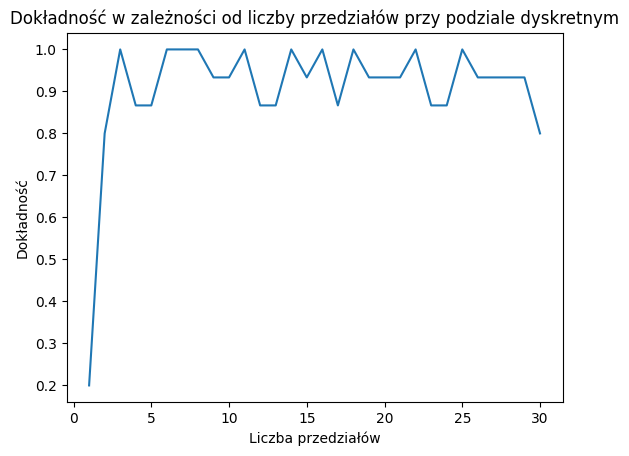

In [31]:

from matplotlib import pyplot as plt

def test_accuracy(naive_bayes, x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    naive_bayes.build_classifier(x_train, y_train)

    accuracies = []
    for i in range(30):
        correct_predictions = 0
        for sample, correct in zip(x_test, y_test):
            prediction = naive_bayes.predict(sample)
            if prediction == correct:
                correct_predictions += 1
        accuracy = correct_predictions / len(y_test)
        accuracies.append(accuracy)
    return sum(accuracies) / len(accuracies)


iris = load_iris()
x = iris.data
y = iris.target

ranges = list(range(1,31,1))
accuracies = []
for i in ranges:
    bayes = NaiveBayes()
    discretised_x = bayes.data_discretization(x, i)
    accuracies.append(test_accuracy(bayes, discretised_x, y, test_size=0.1))



plt.plot(ranges, accuracies)
plt.title("Dokładność w zależności od liczby przedziałów przy podziale dyskretnym")
plt.xlabel("Liczba przedziałów")
plt.ylabel("Dokładność")
plt.show()
    

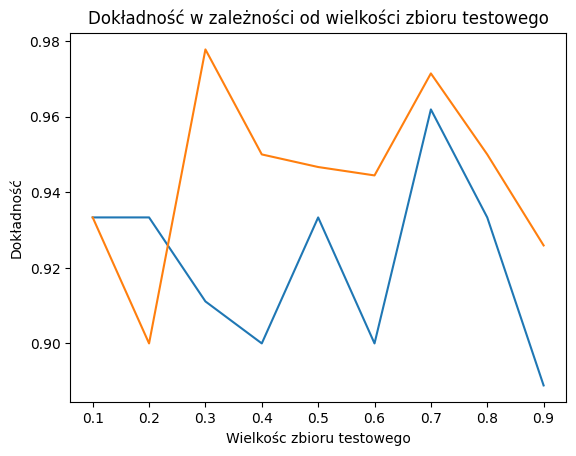

In [32]:
iris = load_iris()
x = iris.data
y = iris.target

test_sizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
accuracies1 = []
for i in test_sizes:
    bayes = NaiveBayes()
    discretised_x = bayes.data_discretization(x, 4)
    accuracies1.append(test_accuracy(bayes, discretised_x, y, test_size=i))

accuracies2 = []
for i in test_sizes:
    g_bayes = GaussianNaiveBayes()
    accuracies2.append(test_accuracy(g_bayes, x, y, test_size=i))




plt.plot(test_sizes, accuracies1, label="NaiveBayes")
plt.plot(test_sizes, accuracies2, label="GaussianNaiveBayes")
plt.title("Dokładność w zależności od wielkości zbioru testowego")
plt.xlabel("Wielkośc zbioru testowego")
plt.ylabel("Dokładność")
plt.show()